In [1]:
import talib
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from sklearn.cluster import KMeans
from statsmodels.regression.rolling import RollingOLS
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

warnings.filterwarnings("ignore")

In [2]:
def compute_atr(stock_data: pd.DataFrame):
    """
    Here why atr needs to subtract mean and divided by std, because we want to have zero-mean and 1-std series.
    However, this is in fact cheating, since we are subtracting the mean at each data-point, which is impossible in
    real-time processing. Think about day T, we do not know the mean that also includes data from day T+1 to day N.
    """
    atr = talib.ATR(stock_data["high"], stock_data["low"], stock_data["adj close"], timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

def compute_macd(close: pd.Series):
    """
    Again this is cheating, same reason as compute_atr.
    """
    macd = talib.MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

def calculate_returns(df: pd.DataFrame):
    outlier_cutoff, lags = 0.005, [1, 2, 3, 6, 9, 12]

    _l = lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff))

    for lag in lags: df[f"return_{lag}m"] = df["adj close"].pct_change(lag).pipe(_l).add(1).pow(1/lag).sub(1)

    return df

def get_clusters(df: pd.DataFrame, initial_centroids: np.ndarray):
    df["cluster"] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_

    return df

def plot_clusters(data: pd.DataFrame):
    cluster_0 = data[data["cluster"] == 0]
    cluster_1 = data[data["cluster"] == 1]
    cluster_2 = data[data["cluster"] == 2]
    cluster_3 = data[data["cluster"] == 3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color="red", label="cluster 0")
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color="green", label="cluster 1")
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color="blue", label="cluster 2")
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color="black", label="cluster 3")

    plt.legend()
    plt.show()

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-")
symbols_list = sp500["Symbol"].unique().tolist()

# ns100 = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
# ns100["Symbol"] = ns100["Symbol"].str.replace(".", "-")
# symbols_list = ns100["Symbol"].unique().tolist()

end_date = "2024-12-31"

start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(symbols_list, start=start_date, end=end_date).stack()
df = df.rename_axis(None, axis=1)
df.index.names = ["date", "ticker"]
df.columns = df.columns.str.lower()

pd.concat([df.head(3), df.tail(3)])

[*********************100%***********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2017-01-03 A        43.824722   46.490002   46.750000   45.740002   45.930000   
           AAPL     26.891960   29.037500   29.082500   28.690001   28.950001   
           ABBV     44.265297   62.410000   63.029999   61.939999   62.919998   
2024-12-11 ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

                        volume  
date       ticker               
2017-01-03 A         1739600.0  
           AAPL    115127600.0  
           ABBV      9328200.0  
2024-12-11 ZBH       1575000.0  
           ZBRA       328500.0  
           ZTS       1782400.0

## **2. Calculate features and technical indicators for each stock.**
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [4]:
"""
We are not using pandas_ta here, because in the pandas_ta library it will search for if the system has talib installed. If installed, it will use talib to compute the indicators, since our system has talib installed, so we will use it directly.
"""
_rsi = lambda x: talib.RSI(x, timeperiod=20)
_bb_low = lambda x: talib.BBANDS(np.log1p(x), timeperiod=20)[2]
_bb_mid = lambda x: talib.BBANDS(np.log1p(x), timeperiod=20)[1]
_bb_high = lambda x: talib.BBANDS(np.log1p(x), timeperiod=20)[0]
_atr = lambda x: talib.ATR(x["high"], x["low"], x["adj close"], timeperiod=14)
_macd = lambda x: talib.MACD(x)[0]

_x = np.power(np.log(df["high"]) - np.log(df["low"]), 2) / 2
_y = (2 * np.log(2) - 1)
_z = np.power(np.log(df["close"]) - np.log(df["open"]), 2)

df["garman_klass_vol"] = _x - _y * _z
df["rsi"] = df.groupby(level="ticker")["adj close"].transform(_rsi)
df["bb_low"] = df.groupby(level="ticker")["adj close"].transform(_bb_low)
df["bb_mid"] = df.groupby(level="ticker")["adj close"].transform(_bb_mid)
df["bb_high"] = df.groupby(level="ticker")["adj close"].transform(_bb_high)
df["macd"] = df.groupby(level="ticker")["adj close"].transform(_macd)
df["atr"] = df.groupby(level="ticker", group_keys=False).apply(_atr)
df["dollar_volume"] = (df["adj close"] * df["volume"]) / 1e6

pd.concat([df.head(3), df.tail(3)])

adj close       close        high         low        open  \
date       ticker                                                               
2017-01-03 A        43.824722   46.490002   46.750000   45.740002   45.930000   
           AAPL     26.891960   29.037500   29.082500   28.690001   28.950001   
           ABBV     44.265297   62.410000   63.029999   61.939999   62.919998   
2024-12-11 ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-01-03 A         1739600.0          0.000182        NaN       NaN   
           AAPL    115127600.0          0.000089        NaN       NaN   
           ABBV      9328200.0          0.000127        NaN       NaN   
2024-12-11 ZBH       1575000.0          0.000113  45.478295  4.682630   
           ZBRA       328500.0          0.000163  57.743597  5.946741   
           ZTS       1782400.0          0.000095  47.287995  5.166246   

                     bb_mid   bb_high      macd       atr  dollar_volume  
date       ticker                                                         
2017-01-03 A            NaN       NaN       NaN       NaN      76.237487  
           AAPL         NaN       NaN       NaN       NaN    3096.006831  
           ABBV         NaN       NaN       NaN       NaN     412.915543  
2024-12-11 ZBH     4.710679  4.738728  0.073701  2.218256     168.383256  
           ZBRA    5.993380  6.040020  6.353892  7.553221     132.769849  
           ZTS     5.178068  5.189891 -0.920556  3.625792     315.787805

## **3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.**

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ["dollar_volume", "open", "high", "low", "close", "volume"]]

data = pd.concat([
    df.unstack("ticker")["dollar_volume"].resample("M").mean().stack("ticker").to_frame("dollar_volume"),
    df.unstack("ticker")[last_cols].resample("M").last().stack("ticker")],
    axis=1).dropna(axis=0)

pd.concat([data.head(3), data.tail(3)])

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-02-28 A           98.459303   48.358959          0.000026  63.231870   
           AAPL      3730.196863   31.854513          0.000014  88.225194   
           ABBV       293.042513   44.303562          0.000058  52.357074   
2024-12-31 ZBH        139.763677  106.910004          0.000113  45.478295   
           ZBRA       116.551256  404.170013          0.000163  57.743597   
           ZTS        410.320172  177.169998          0.000095  47.287995   

                     bb_low    bb_mid   bb_high      macd        atr  
date       ticker                                                     
2017-02-28 A       3.845834  3.883584  3.921333  0.841642   3.271248  
           AAPL    3.400463  3.462253  3.524044  1.025600   2.549562  
           ABBV    3.784566  3.803218  3.821869  0.047519  17.860072  
2024-12-31 ZBH     4.682630  4.710679  4.738728  0.073701   2.218256  
           ZBRA    5.946741  5.993380  6.040020  6.353892   7.553221  
           ZTS     5.166246  5.178068  5.189891 -0.920556   3.625792

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [6]:
data["dollar_volume"] = data.loc[:, "dollar_volume"].unstack("ticker").rolling(window=5*12, min_periods=12).mean().stack()
data["dollar_vol_rank"] = data.groupby("date")["dollar_volume"].rank(ascending=False)
data = data[data["dollar_vol_rank"] < 150].drop(["dollar_volume", "dollar_vol_rank"], axis=1)

pd.concat([data.head(3), data.tail(3)])

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388081          0.000063  40.100787  3.695993   
           ABBV     83.089912          0.000575  62.305716  4.236627   
           ABT      55.295002          0.000082  69.274969  3.936873   
2024-12-31 WMT      94.959999          0.000071  72.966895  4.429662   
           XOM     111.919998          0.000065  35.805788  4.723061   
           ZTS     177.169998          0.000095  47.287995  5.166246   

                     bb_mid   bb_high      macd        atr  
date       ticker                                           
2018-01-31 AAPL    3.736405  3.776816 -0.232711   2.767358  
           ABBV    4.368567  4.500507  3.653830  29.403734  
           ABT     3.995678  4.054483  1.382374   7.330254  
2024-12-31 WMT     4.515981  4.602301  3.029705   1.450671  
           XOM     4.775636  4.828211 -1.625512   2.030881  
           ZTS     5.178068  5.189891 -0.920556   3.625792

## **4. Calculate Monthly Returns for different time horizons as features.**

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [7]:
data = data.groupby(level="ticker", group_keys=False).apply(calculate_returns).dropna(axis=0)

pd.concat([data.head(3), data.tail(3)])

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743027          0.000353  53.482563  3.564609   
           ABBV     62.078793          0.000419  41.951150  4.108503   
           ABT      66.100266          0.000151  56.879250  4.115730   
2024-12-31 WFC      71.599998          0.000135  54.066859  4.277448   
           WMT      94.959999          0.000071  72.966895  4.429662   
           XOM     111.919998          0.000065  35.805788  4.723061   

                     bb_mid   bb_high      macd        atr  return_1m  \
date       ticker                                                       
2019-01-31 AAPL    3.630896  3.697183 -0.120788   2.432627   0.055154   
           ABBV    4.201370  4.294236 -1.494545  20.598839  -0.118400   
           ABT     4.161145  4.206561  0.457336   7.580241   0.013665   
2024-12-31 WFC     4.321351  4.365255  1.308335   1.691386  -0.059997   
           WMT     4.515981  4.602301  3.029705   1.450671   0.026595   
           XOM     4.775636  4.828211 -1.625512   2.030881  -0.051204   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-01-31 AAPL    -0.034589  -0.086165  -0.020933   0.001996    0.000748  
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001  
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985  
2024-12-31 WFC      0.053210   0.084290   0.033951   0.025934    0.033971  
           WMT      0.076455   0.055519   0.058491   0.052742    0.051082  
           XOM     -0.017016  -0.012615  -0.001996  -0.001508    0.012271

## **5. Download Fama-French Factors and Calculate Rolling Factor Betas.**

* We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [8]:
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start="2010")[0].drop("RF", axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample("M").last().div(100)

factor_data.index.names = ["date"]

factor_data = factor_data.join(data["return_1m"], how="left").sort_index(ascending=True)

pd.concat([factor_data.head(3), factor_data.tail(3)])

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV    0.0840  0.0301 -0.0045 -0.0078 -0.0152  -0.118400
           ABT     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.013665
2024-10-31 WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

In [9]:
observations = factor_data.groupby(level="ticker").size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values("ticker").isin(valid_stocks.index)]

pd.concat([factor_data.head(3), factor_data.tail(3)])

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV    0.0840  0.0301 -0.0045 -0.0078 -0.0152  -0.118400
           ABT     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.013665
2024-10-31 WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

* In order to compute Fama-French factors for each ticker, we apply RollingOLS on each ticker, you can simply think about this
* is a linear regression based on the target value (return_1m).

In [10]:
_rolling = lambda x: RollingOLS(endog=x["return_1m"],
                                exog=sm.add_constant(x.drop("return_1m", axis=1)),
                                window=min(24, x.shape[0]),
                                min_nobs=len(x.columns)+1).fit(params_only=True).params.drop("const", axis=1)

betas = factor_data.groupby(level="ticker", group_keys=False).apply(_rolling)

# keep left, so no ticker missed, shift 1 because the RollingOLS is right-inclusive (see pandas rolling 'closed' parameter)
data = data.join(betas.groupby("ticker").shift(periods=1), how="left")

pd.concat([data.head(3), data.tail(3)])

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743027          0.000353  53.482563  3.564609   
           ABBV     62.078793          0.000419  41.951150  4.108503   
           ABT      66.100266          0.000151  56.879250  4.115730   
2024-12-31 WFC      71.599998          0.000135  54.066859  4.277448   
           WMT      94.959999          0.000071  72.966895  4.429662   
           XOM     111.919998          0.000065  35.805788  4.723061   

                     bb_mid   bb_high      macd        atr  return_1m  \
date       ticker                                                       
2019-01-31 AAPL    3.630896  3.697183 -0.120788   2.432627   0.055154   
           ABBV    4.201370  4.294236 -1.494545  20.598839  -0.118400   
           ABT     4.161145  4.206561  0.457336   7.580241   0.013665   
2024-12-31 WFC     4.321351  4.365255  1.308335   1.691386  -0.059997   
           WMT     4.515981  4.602301  3.029705   1.450671   0.026595   
           XOM     4.775636  4.828211 -1.625512   2.030881  -0.051204   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-01-31 AAPL    -0.034589  -0.086165  -0.020933   0.001996    0.000748   
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001   
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985   
2024-12-31 WFC      0.053210   0.084290   0.033951   0.025934    0.033971   
           WMT      0.076455   0.055519   0.058491   0.052742    0.051082   
           XOM     -0.017016  -0.012615  -0.001996  -0.001508    0.012271   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2019-01-31 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
2024-12-31 WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN

In [11]:
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]

"""
We should not fill those na rows, otherwise it is look-ahead, think about filling 2019 rows with mean computed from
later date or, we can think about when we are computing RSI with window size is 14, we should not fill the first 14 rows
with mean of RSI computed from 15th row and beyond.
"""
# data.loc[:, factors] = data.groupby(level="ticker", group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop("adj close", axis=1).dropna(axis=0)

pd.concat([data.head(3), data.tail(3)])

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2021-01-31 AAPL            0.000874  51.602274  4.799064  4.875032  4.951000   
           ABBV            0.000254  44.922923  4.481462  4.541815  4.602168   
           ABT             0.000551  75.566211  4.601101  4.664535  4.727969   
2024-10-31 WFC             0.000145  65.756087  4.041973  4.144185  4.246397   
           WMT             0.000086  58.175627  4.381914  4.409462  4.437010   
           XOM             0.000139  45.331616  4.754263  4.794192  4.834121   

                       macd        atr  return_1m  return_2m  return_3m  \
date       ticker                                                         
2021-01-31 AAPL    2.841344   5.507198  -0.005501   0.052826   0.066860   
           ABBV    0.466575  16.224774  -0.032397  -0.004319   0.068038   
           ABT     2.519138   9.522730   0.133326   0.070806   0.056887   
2024-10-31 WFC     2.287794   1.467473   0.149230   0.053714   0.033028   
           WMT     0.837140   1.040933   0.014861   0.030105   0.061865   
           XOM    -0.200876   2.337555  -0.003754  -0.004930  -0.002451   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2021-01-31 AAPL     0.037371   0.068004    0.046237  1.445994 -0.653567   
           ABBV     0.017127   0.029058    0.024210  0.118594  1.555594   
           ABT      0.036098   0.034519    0.030874  0.877733 -0.556075   
2024-10-31 WFC      0.017408   0.031357    0.044222  1.108944 -0.146507   
           WMT      0.056357   0.046256    0.035781  0.695971  0.009131   
           XOM      0.000572   0.017119    0.011122  0.627205 -0.089218   

                        HML       RMW       CMA  
date       ticker                                
2021-01-31 AAPL   -0.381449  0.975152  1.118146  
           ABBV   -0.304472  1.054444  1.295570  
           ABT    -0.512469  0.497460  0.620032  
2024-10-31 WFC     1.284970 -0.756494 -0.749953  
           WMT    -0.193100  1.168087  0.078277  
           XOM     0.429841  0.793879  0.801531

## **6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.**

In [12]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), data.shape[1]))

initial_centroids[:, 1] = target_rsi_values

data = data.groupby(level="date", group_keys=False).apply(get_clusters, initial_centroids=initial_centroids)

pd.concat([data.head(3), data.tail(3)])

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2021-01-31 AAPL            0.000874  51.602274  4.799064  4.875032  4.951000   
           ABBV            0.000254  44.922923  4.481462  4.541815  4.602168   
           ABT             0.000551  75.566211  4.601101  4.664535  4.727969   
2024-10-31 WFC             0.000145  65.756087  4.041973  4.144185  4.246397   
           WMT             0.000086  58.175627  4.381914  4.409462  4.437010   
           XOM             0.000139  45.331616  4.754263  4.794192  4.834121   

                       macd        atr  return_1m  return_2m  return_3m  \
date       ticker                                                         
2021-01-31 AAPL    2.841344   5.507198  -0.005501   0.052826   0.066860   
           ABBV    0.466575  16.224774  -0.032397  -0.004319   0.068038   
           ABT     2.519138   9.522730   0.133326   0.070806   0.056887   
2024-10-31 WFC     2.287794   1.467473   0.149230   0.053714   0.033028   
           WMT     0.837140   1.040933   0.014861   0.030105   0.061865   
           XOM    -0.200876   2.337555  -0.003754  -0.004930  -0.002451   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2021-01-31 AAPL     0.037371   0.068004    0.046237  1.445994 -0.653567   
           ABBV     0.017127   0.029058    0.024210  0.118594  1.555594   
           ABT      0.036098   0.034519    0.030874  0.877733 -0.556075   
2024-10-31 WFC      0.017408   0.031357    0.044222  1.108944 -0.146507   
           WMT      0.056357   0.046256    0.035781  0.695971  0.009131   
           XOM      0.000572   0.017119    0.011122  0.627205 -0.089218   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2021-01-31 AAPL   -0.381449  0.975152  1.118146        2  
           ABBV   -0.304472  1.054444  1.295570        1  
           ABT    -0.512469  0.497460  0.620032        3  
2024-10-31 WFC     1.284970 -0.756494 -0.749953        2  
           WMT    -0.193100  1.168087  0.078277        2  
           XOM     0.429841  0.793879  0.801531        1

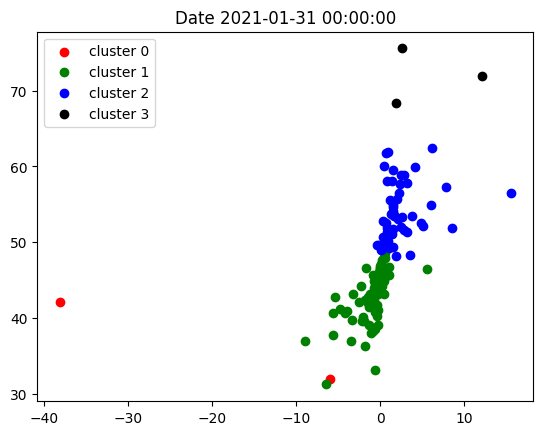

In [13]:
for d in data.index.get_level_values("date").unique().tolist()[:1]:
    g = data.xs(d, level="date")
    plt.title(f"Date {d}")
    plot_clusters(g)

## **7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization**

In [14]:
"""
Here, we shifted 1-day so the entry is the 1st day of each month, and we are buying the stocks that belong to cluster 3
which are computed based on last month data, hence no look-ahead.

The buying logic is as follows:
1. we find out the top 150 stocks with most volatility based on ranking dollar_volume indicator
2. we combine the Fama-French factors which is resample into monthly level
3. we then perform RollingOLS to future specify the Fama-French factors for each tickers
4. we perform a K-mean clustering algorithm, to group tickers into different clusters based on RSI, MACD, ...
5. we shift the date by 1-day, now this is our entry date, and the tickers we are buying are those belongs to cluster 3

The buying logic can be seen as a monthly re-balance strategy
"""

filtered_df = data[data["cluster"] == 3].copy()
filtered_df = filtered_df.reset_index(level="ticker")
filtered_df.index = filtered_df.index + pd.DateOffset(days=1)
filtered_df = filtered_df.reset_index().set_index(["date", "ticker"])

dates = filtered_df.index.get_level_values("date").unique().tolist()
fixed_dates = {d.strftime("%Y-%m-%d") : filtered_df.xs(d, level="date").index.tolist() for d in dates}

next(iter(fixed_dates.items())).__str__()

"('2021-02-01', ['ABT', 'LLY', 'WBA'])"

### **Define portfolio optimization function**

In [15]:
stocks = data.index.get_level_values("ticker").unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values("date").unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values("date").unique()[-1],
                     timeout=60)

[*********************100%***********************]  154 of 154 completed


In [49]:
returns_dataframe, portfolio_df = np.log(new_df["Adj Close"]).diff(), pd.DataFrame()

for s_date, tickers in fixed_dates.items():

    e_date = (pd.to_datetime(s_date) + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")

    opt_s_date = (pd.to_datetime(s_date) - pd.DateOffset(months=12)).strftime("%Y-%m-%d")
    opt_e_date = (pd.to_datetime(s_date) - pd.DateOffset(days=1)).strftime("%Y-%m-%d")
    opt_df = new_df[opt_s_date:opt_e_date]["Adj Close"][tickers]
    lower_bound = round(1 / (len(tickers) * 2), 3)

    weights = None
    try:
        exp_return = expected_returns.mean_historical_return(prices=opt_df, frequency=opt_df.shape[0])
        cov_matrix = risk_models.sample_cov(prices=opt_df, frequency=opt_df.shape[0])
        ef = EfficientFrontier(expected_returns=exp_return,
                               cov_matrix=cov_matrix,
                               weight_bounds=(lower_bound, 0.1),
                               solver="SCS")

        weights = ef.max_sharpe().clean_weights()
        weights = pd.DataFrame(weights, index=pd.Series(0))
        weights.index.name = "index"

    except (ValueError, Exception) as e:
        # print(f"Max Sharpe optimization failed for period: {s_date} - {e_date}, tickers: {tickers}")
        pass

    finally:
        if weights is None:
            weights = pd.DataFrame([1 / len(tickers) for i in range(len(tickers))],
                                   index=tickers,
                                   columns=pd.Series(0)).T

            weights.index.name = "index"

    temp_df = returns_dataframe[s_date:e_date]

    # why we have empty df here because Fama/French 5 Factors (2x3) data does not have that month yet
    if temp_df.empty: continue

    temp_df = temp_df.stack().to_frame("return")
    if temp_df.index.name is None: temp_df.index.names = ["date", "ticker"]

    temp_df = temp_df.reset_index(level="date")
    temp_df = temp_df.merge(weights.stack().to_frame("weight").reset_index(level="index", drop=True),
                            left_index=True,
                            right_index=True)

    temp_df = temp_df.reset_index().set_index(["date", "ticker"]).unstack().stack()
    temp_df.index.names = ["date", "ticker"]
    temp_df["weighted_return"] = temp_df["return"] * temp_df["weight"]
    temp_df = temp_df.groupby(level="date")["weighted_return"].sum().to_frame("Strategy Return")

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df = portfolio_df.drop_duplicates()

pd.concat([portfolio_df.head(3), portfolio_df.tail(3)])

,Strategy Return
date,
2021-02-01,-0.020232
2021-02-02,-0.018273
2021-02-03,0.002081
2024-10-28,-0.000053
2024-10-29,0.018222
2024-10-30,0.008185


## **8. Visualize Portfolio returns and compare to SP500 returns**

In [36]:
spy_df = yf.download(tickers="SPY",
                     start=portfolio_df.index[0].strftime("%Y-%m-%d"),
                     end=portfolio_df.index[-1].strftime("%Y-%m-%d"))

spy_return = np.log(spy_df[["Adj Close"]]).diff().dropna().rename({"Adj Close": "SPY Buy&Hold"}, axis=1)

portfolio_df = portfolio_df.merge(spy_return["SPY Buy&Hold"], left_index=True, right_index=True)

pd.concat([portfolio_df.head(3), portfolio_df.tail(3)])

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY
2021-02-02,-0.018273,0.014041
2021-02-03,0.002081,0.000786
2021-02-04,0.008974,0.011302
2024-10-25,0.002093,-0.000345
2024-10-28,-0.000053,0.003087
2024-10-29,0.018222,0.001617


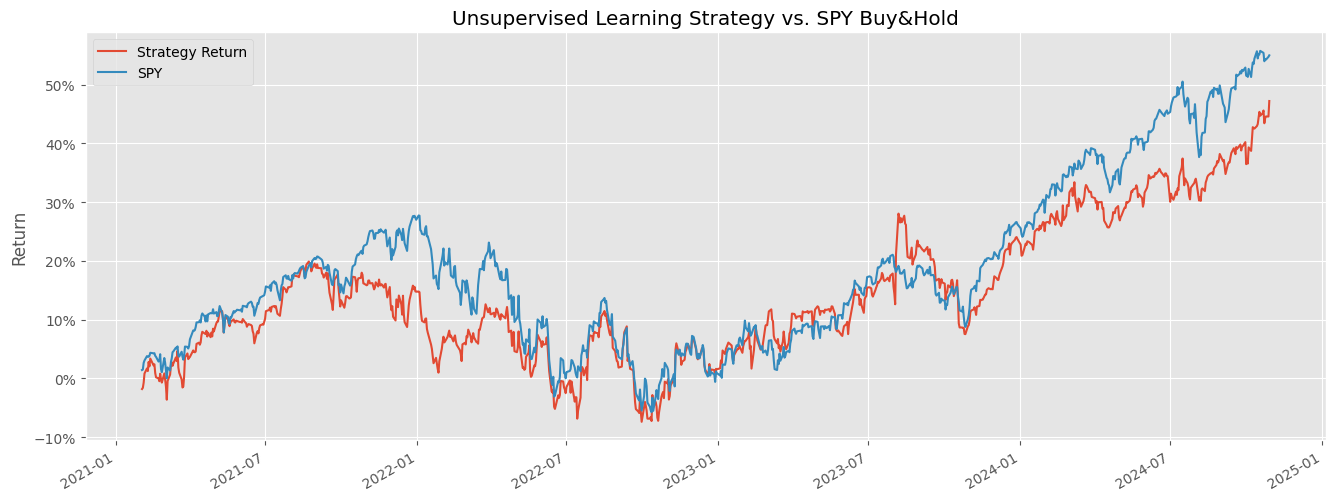

In [37]:
plt.style.use("ggplot")

portfolio_cumulative_returns = np.exp(np.log1p(portfolio_df).cumsum()) - 1

portfolio_cumulative_returns.plot(figsize=(16, 6))

plt.title("Unsupervised Learning Strategy vs. SPY Buy&Hold")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel("Return")

plt.show()